# Generación de Predicciones con Regresión Lineal
Este notebook implementa una regresión lineal para predecir valores en un conjunto de datos simulados.

## 1. Importación de Bibliotecas

In [44]:
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

import openpyxl
import warnings
import re

import plotly.express as px

## 2. Extracción y limpieza de datos

<span style="color:white; font-weight:bold">2.1 Extracción</span>

Los datos se generaron directamente de la base de datos MSSQL con las ventas reales de la empresa HBS-Delli, del 2020 a la fecha (diciembre 2024).

In [47]:
df = pd.read_excel("../data/Ventas_CapstoneProject_Agrupado.xlsx", sheet_name="Por_Semana")

**2.2 funciones**

In [45]:
def eliminar_datos_atipicos(input_df):
    
    # Calcular Q1 (percentil 25) y Q3 (percentil 75)
    Q1 = input_df['cantidad'].quantile(0.25)
    Q3 = input_df['cantidad'].quantile(0.75)
    IQR = Q3 - Q1

    # Definir límites para valores no atípicos
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar el DataFrame eliminando valores atípicos
    df_sin_picos = input_df[(input_df['cantidad'] >= lower_bound) & (input_df['cantidad'] <= upper_bound)]

    #Comentar si se quieren utilizar datos atipicos
    #df = df_sin_picos

    return df_sin_picos

<span style="color:white; font-weight:bold">2.2 Limpieza</span>

La mayor parte de la limpieza de datos se realizaron directamente en la base de datos MSSQL, sin embargo se utilizo pandas para realizar una validación de la información y preparar el dataset para su analisis.

In [46]:
#validar nulos
if df.isnull().sum().sum() > 0:
    df = df.dropna()
    print("Se eliminaron las filas con valores nulos.")
else:
    print("No se encontraron valores nulos en el DataFrame.")

# Preparando información de la venta
df = df.rename(columns={'FechaEmision': 'fecha_emision'
                        , "Empresa": "empresa"
                        , "Anio": "anio"
                        , "Fecha_Inicio_Semana": "fecha_inicio_semana"
                        })

# Preparando informacion del artículo
df['numero_articulo'] = pd.to_numeric(
                                    df['Articulo'].str.extract(r'(\d+)')[0]     # Extraer solo números
                                    ,errors='coerce'                            # Convertir valores inválidos a NaN
                                    ).fillna(0).astype(int)                     # Reemplazar NaN por 0 y convertir a entero
df = df.rename(columns={"Articulo": "articulo"
                        ,'Desc_Articulo': 'desc_articulo'
                        , 'FechaEmision': 'fecha_emision'
                        , "Empresa": "empresa"
                        , "Mov": "mov"
                        , "MovId": "movId"
                        , "Lote": "lote"
                        })

# Preparando información del cliente
df = df.rename(columns={'Numero_Cliente': 'numero_cliente'
                        , 'Nombre_Cliente': 'nombre_cliente'
                        , "Rama": "rama_cliente"
                        , "Tipo" : "tipo_cliente"
                        , "Linea": "linea"
                        , "Modulo": "modulo"
                        })
df['numero_cliente'] = df['numero_cliente'].fillna('Desconocido')

# Preparando información de las cantidad
df = df.rename(columns={"Cantidad": "cantidad"
                        , "Lote": "lote"
                        , "UM": "unidad_medida"
                        , "Precio": "precio"
                        , "SubTotal": "subTotal"
                        , "DescuentoLineal": "descuento_lineal"
                        , "IVA": "iva"
                        , "IEPS": "ieps"
                        , "ImporteTotal": "importe_total"
                        , "Costo_Unitario": "costo_unitario"
                        , "Costo_Total": "costo_total"
                          })

# Eliminando información no requerida para el analisis
df = df.drop(columns=["IEPS_Cuota", "Numero_Orden"])

print(f"Filas antes de eliminar atípicos: {len(df)}")
df = eliminar_datos_atipicos(df)
print(f"Filas antes de eliminar atípicos: {len(df)}")

No se encontraron valores nulos en el DataFrame.


KeyError: 'Articulo'

In [16]:
# Agrupar por fecha y sumar 'ImporteTotal' (como ejemplo de serie temporal)
serie_temporal = df.groupby('fecha_emision')['cantidad'].sum().reset_index()

# Aplicar la prueba ADF a la columna 'ImporteTotal'
resultado_adf = adfuller(serie_temporal['cantidad'])

# Mostrar los resultados
print("Resultados de la Prueba de Dickey-Fuller:")
print(f"Estadístico de prueba: {resultado_adf[0]:.4f}")
print(f"P-valor: {resultado_adf[1]:.4f}")
print("Valores críticos:")
for key, value in resultado_adf[4].items():
    print(f"  {key}: {value:.4f}")

Resultados de la Prueba de Dickey-Fuller:
Estadístico de prueba: -2.5514
P-valor: 0.1035
Valores críticos:
  1%: -3.4362
  5%: -2.8641
  10%: -2.5681


**Revisión de la información**


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115696 entries, 0 to 126282
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fecha_emision        115696 non-null  datetime64[ns]
 1   anio                 115696 non-null  int64         
 2   Semana_Anio          115696 non-null  int64         
 3   fecha_inicio_semana  115696 non-null  datetime64[ns]
 4   empresa              115696 non-null  object        
 5   numero_cliente       115696 non-null  int64         
 6   nombre_cliente       115696 non-null  object        
 7   rama_cliente         115696 non-null  object        
 8   tipo_cliente         115696 non-null  object        
 9   articulo             115696 non-null  object        
 10  desc_articulo        115696 non-null  object        
 11  cantidad             115696 non-null  float64       
 12  precio               115696 non-null  float64       
 13  subTotal           

## 3. División del Conjunto de datos

**3.1: Identificar posibles regresore**

Para determinar qué regresores adicionales serían útiles en tu modelo Prophet, debemos analizar la correlación entre la columna objetivo (Cantidad) y las demás columnas del DataFrame. Esto nos permitirá identificar qué variables explicativas tienen una relación significativa con la variable que quieres predecir

<h4>Pasos:</h4>
<ol>
    <li>Seleccionar columnas númericas</li>
    <li>calcular la correlación con la variable objetivo "Cantidad"</li>
    <li>Identificar las columnas con mas correlación</li>
</ol>

Recomendación: seleccionar las variables con mas alta correlación (+1 ó -1)

In [17]:
# Seleccionar solo las columnas numéricas del DataFrame
numerical_cols = df.select_dtypes(include=['number']).columns

# Calcular la correlación de las columnas numéricas con 'Cantidad'
correlations = df[numerical_cols].corr()['cantidad'].drop('cantidad').sort_values(ascending=False)

# Mostrar las columnas más correlacionadas con 'Cantidad'
print("Correlaciones con la columna 'Cantidad':")
print(correlations)


Correlaciones con la columna 'Cantidad':
Importe_Total      0.846142
iva                0.836665
costo_total        0.832853
subTotal           0.744817
ieps               0.689133
anio               0.051710
Semana_Anio       -0.015167
numero_articulo   -0.026320
costo_unitario    -0.031153
numero_cliente    -0.093246
precio            -0.294439
Name: cantidad, dtype: float64


In [42]:
df["fecha_emision"] =  pd.to_datetime(df["fecha_emision"], errors="coerce" , format="%d/%m/%Y")     #Convirtiendo fecha_emision en conjunto de fechas
df["fecha_inicio_semana"] =  pd.to_datetime(df["fecha_inicio_semana"], errors="coerce" , format="%d/%m/%Y")     #Convirtiendo fecha_emision en conjunto de fechas
df = df.dropna(subset=["fecha_emision"])                                                            #Eliminando posibles fechas invalidas

# Filtrar datos de entrenamiento, validación y futuros
train       = df[df['fecha_inicio_semana'] <= '2023-12-01']
train       = train[train['fecha_inicio_semana'] >= '2022-01-01']
valid       = df[df['fecha_inicio_semana'] >= '2024-01-01']
valid       = valid[valid['fecha_inicio_semana'] < '2024-04-01']

train_full  = df

# Preparar los datos para Prophet
#train_data = train.rename(columns={"fecha_emision": "ds", "cantidad": "y"})[["ds", "y", "numero_cliente", "numero_articulo"]]
#valid_data = valid.rename(columns={"fecha_emision": "ds", "cantidad": "y"})[["ds", "y", "numero_cliente", "numero_articulo"]]

train_data = train.rename(columns={"fecha_inicio_semana": "ds", "cantidad": "y"})[["ds", "y"]]
valid_data = valid.rename(columns={"fecha_inicio_semana": "ds", "cantidad": "y"})[["ds", "y"]]



## 4. Entrenamiento del Modelo Prophet

14:54:29 - cmdstanpy - INFO - Chain [1] start processing
14:54:29 - cmdstanpy - INFO - Chain [1] done processing


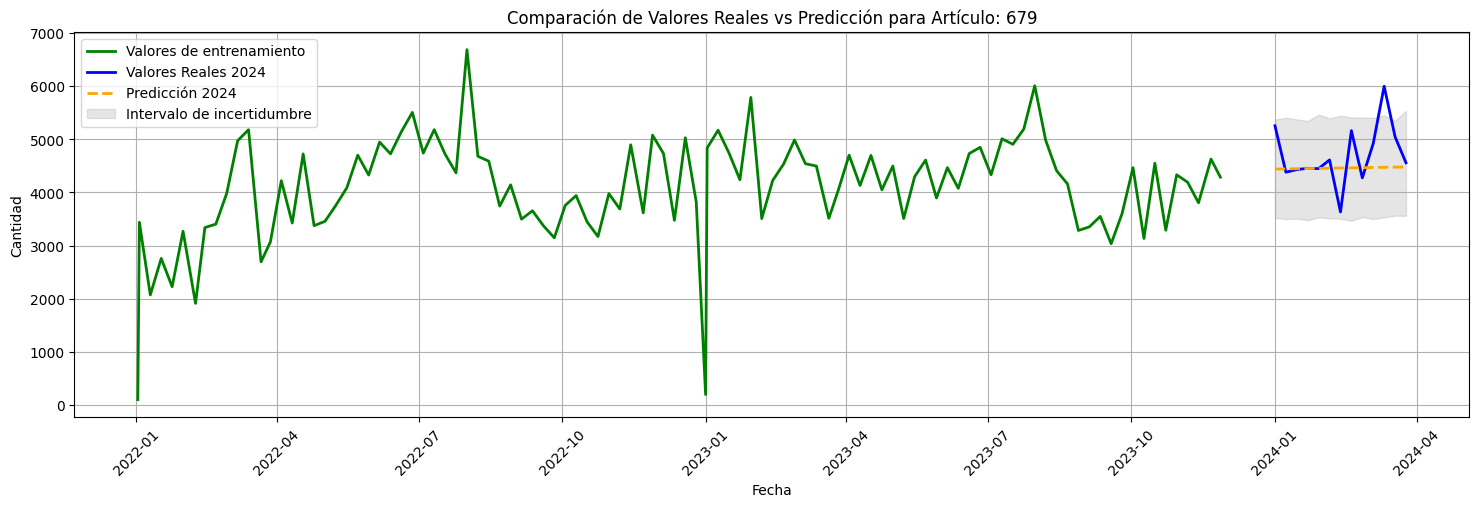

14:54:30 - cmdstanpy - INFO - Chain [1] start processing


MAE (Error Absoluto Medio): 415.81
RMSE (Raíz del Error Cuadrático Medio): 605.73
R2 (Coeficiente de Determinación): -0.18


14:54:30 - cmdstanpy - INFO - Chain [1] done processing


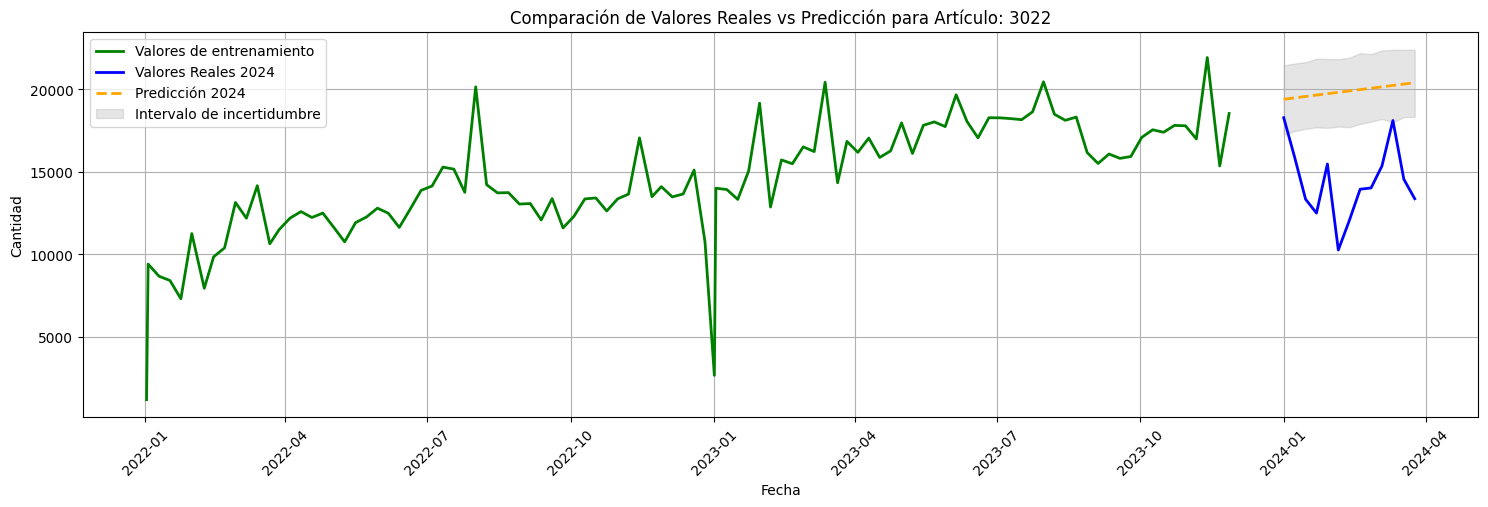

MAE (Error Absoluto Medio): 5501.60
RMSE (Raíz del Error Cuadrático Medio): 5935.10
R2 (Coeficiente de Determinación): -6.40


14:54:31 - cmdstanpy - INFO - Chain [1] start processing
14:54:31 - cmdstanpy - INFO - Chain [1] done processing


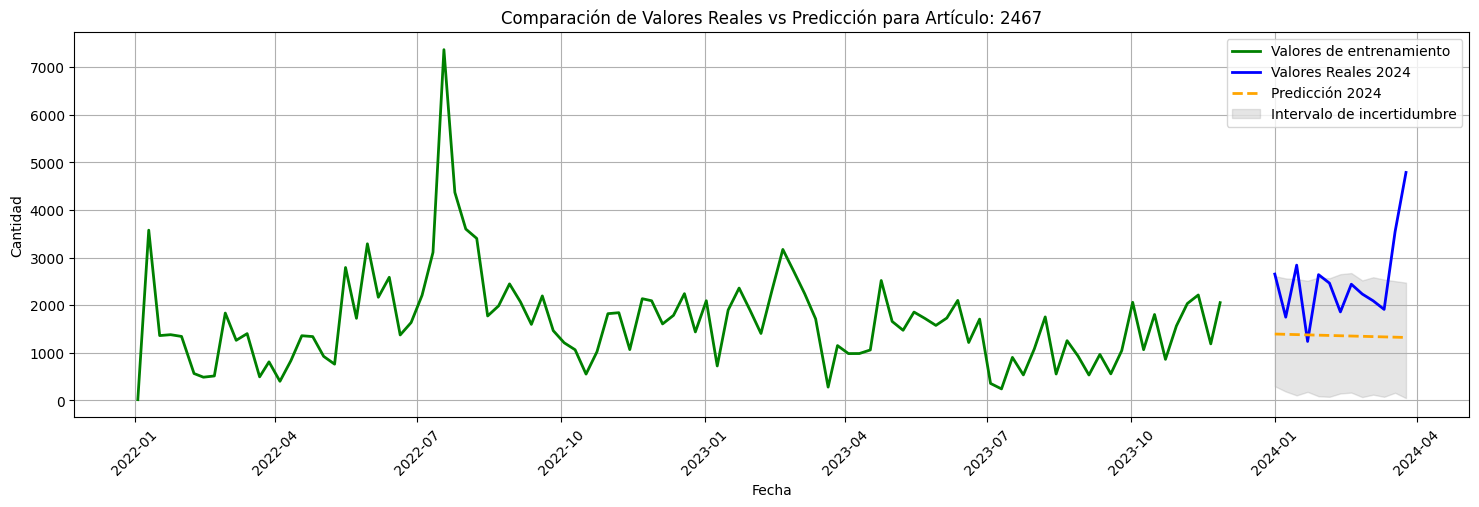

MAE (Error Absoluto Medio): 1159.42
RMSE (Raíz del Error Cuadrático Medio): 1433.76
R2 (Coeficiente de Determinación): -1.77


14:54:33 - cmdstanpy - INFO - Chain [1] start processing
14:54:33 - cmdstanpy - INFO - Chain [1] done processing


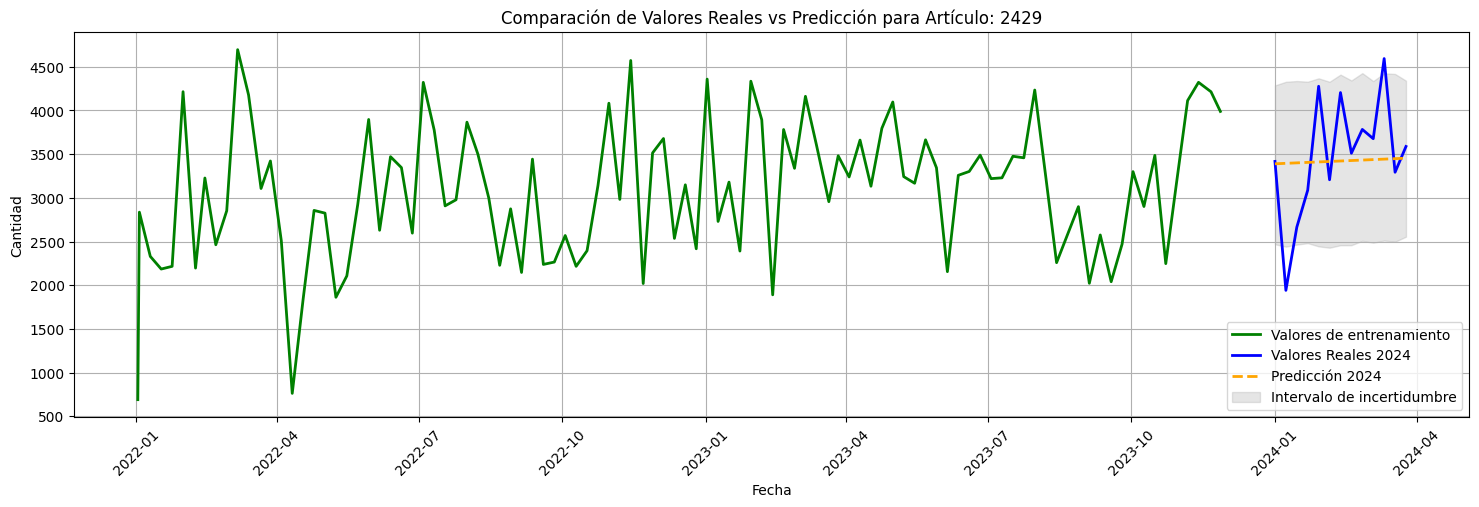

14:54:33 - cmdstanpy - INFO - Chain [1] start processing
14:54:33 - cmdstanpy - INFO - Chain [1] done processing


MAE (Error Absoluto Medio): 500.64
RMSE (Raíz del Error Cuadrático Medio): 663.29
R2 (Coeficiente de Determinación): 0.02


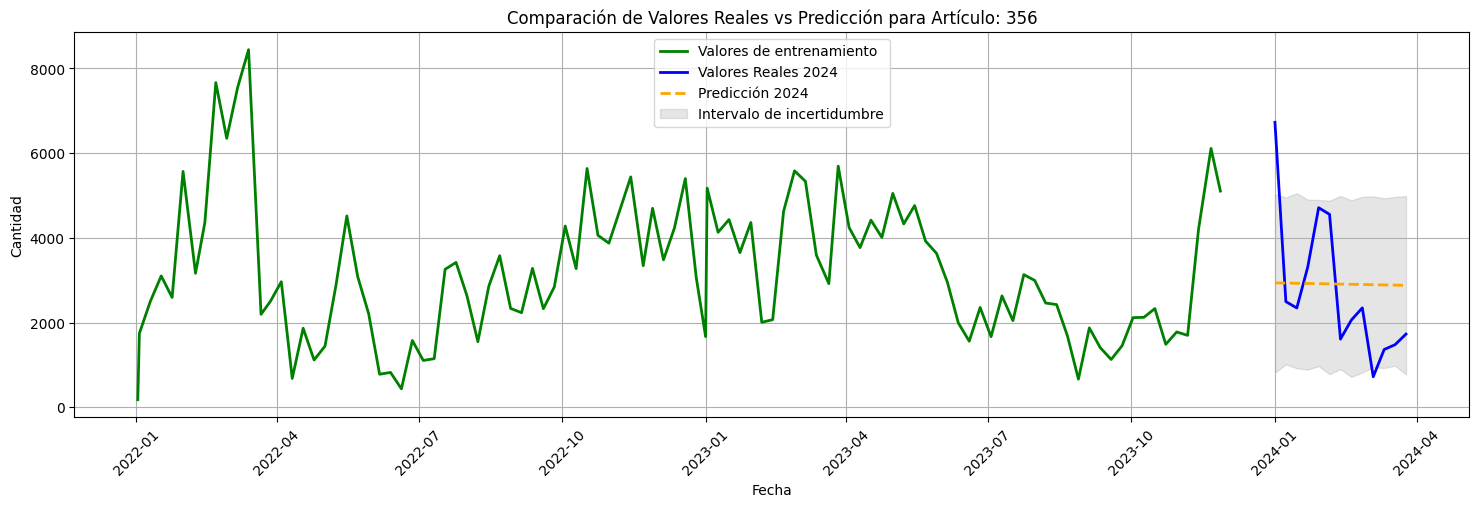

14:54:34 - cmdstanpy - INFO - Chain [1] start processing


MAE (Error Absoluto Medio): 1351.94
RMSE (Raíz del Error Cuadrático Medio): 1617.00
R2 (Coeficiente de Determinación): 0.00


14:54:34 - cmdstanpy - INFO - Chain [1] done processing


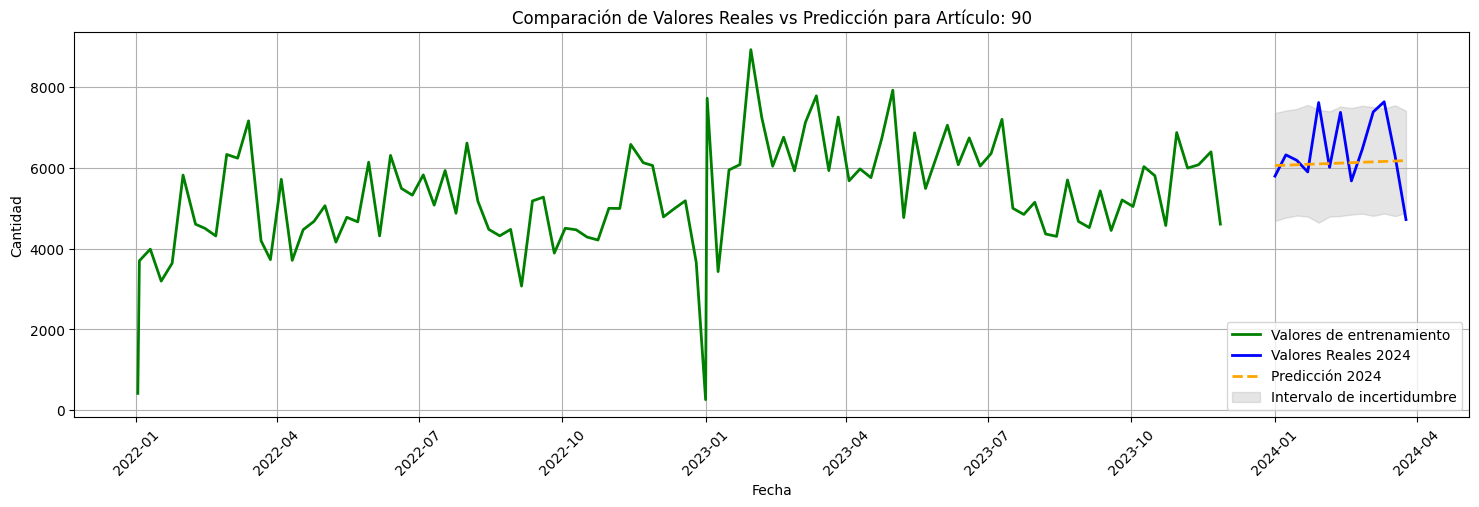

14:54:34 - cmdstanpy - INFO - Chain [1] start processing
14:54:34 - cmdstanpy - INFO - Chain [1] done processing


MAE (Error Absoluto Medio): 673.99
RMSE (Raíz del Error Cuadrático Medio): 887.77
R2 (Coeficiente de Determinación): -0.12


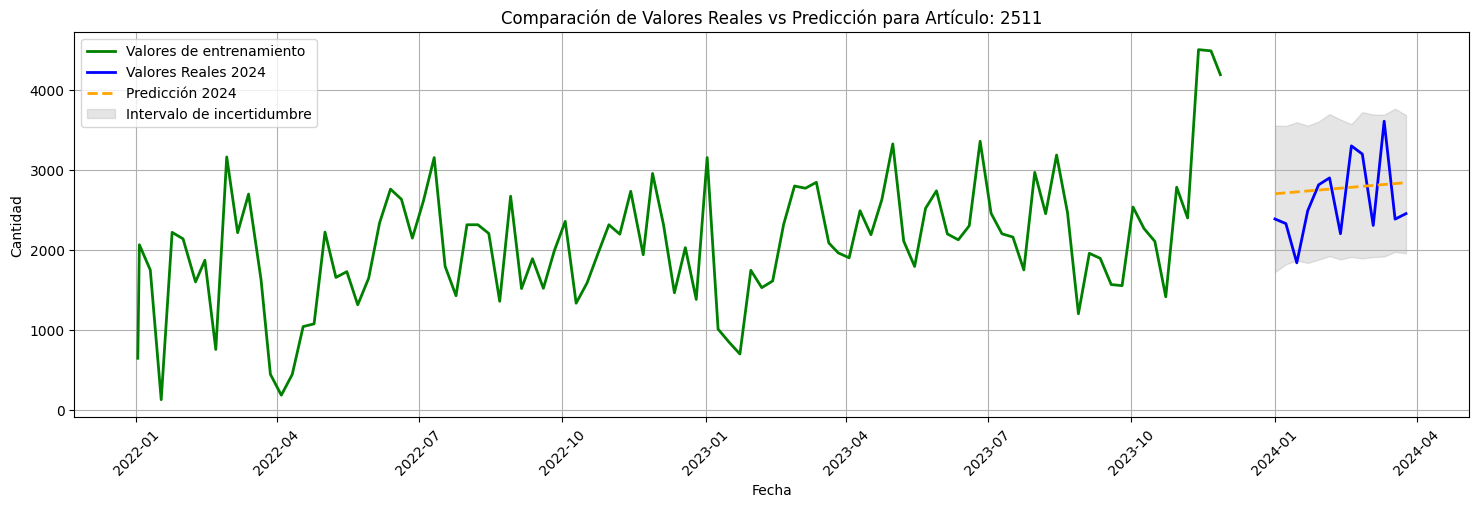

14:54:35 - cmdstanpy - INFO - Chain [1] start processing


MAE (Error Absoluto Medio): 434.53
RMSE (Raíz del Error Cuadrático Medio): 487.73
R2 (Coeficiente de Determinación): -0.03


14:54:35 - cmdstanpy - INFO - Chain [1] done processing


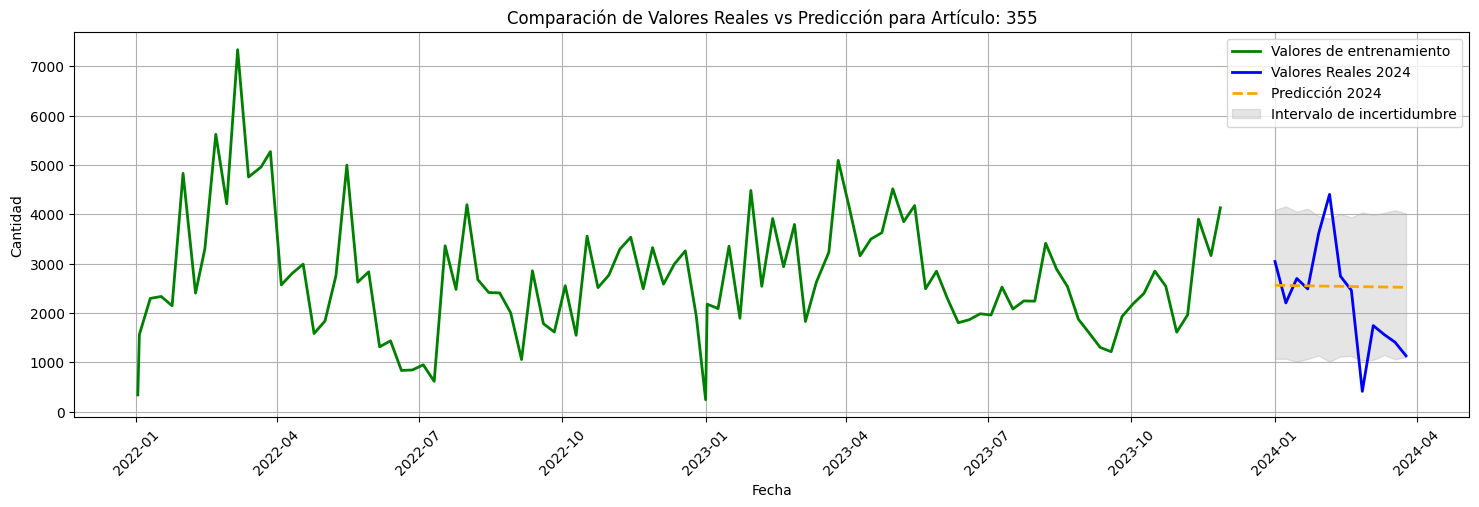

14:54:35 - cmdstanpy - INFO - Chain [1] start processing


MAE (Error Absoluto Medio): 817.80
RMSE (Raíz del Error Cuadrático Medio): 1047.30
R2 (Coeficiente de Determinación): -0.04


14:54:36 - cmdstanpy - INFO - Chain [1] done processing


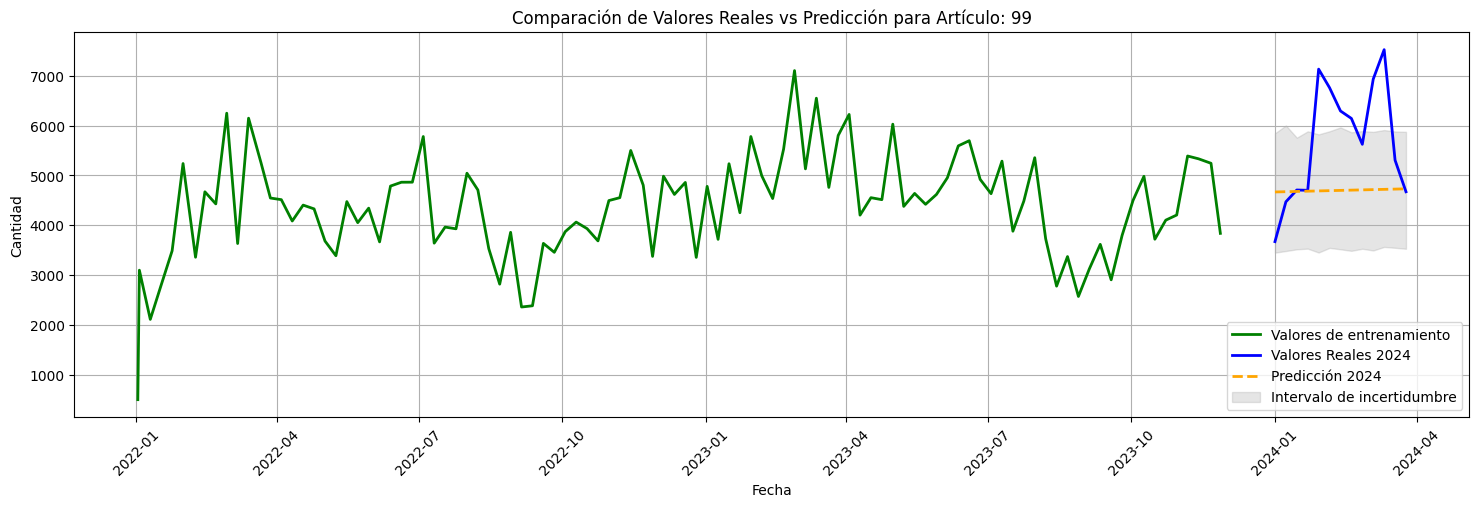

14:54:36 - cmdstanpy - INFO - Chain [1] start processing


MAE (Error Absoluto Medio): 1181.52
RMSE (Raíz del Error Cuadrático Medio): 1514.75
R2 (Coeficiente de Determinación): -0.72


14:54:36 - cmdstanpy - INFO - Chain [1] done processing


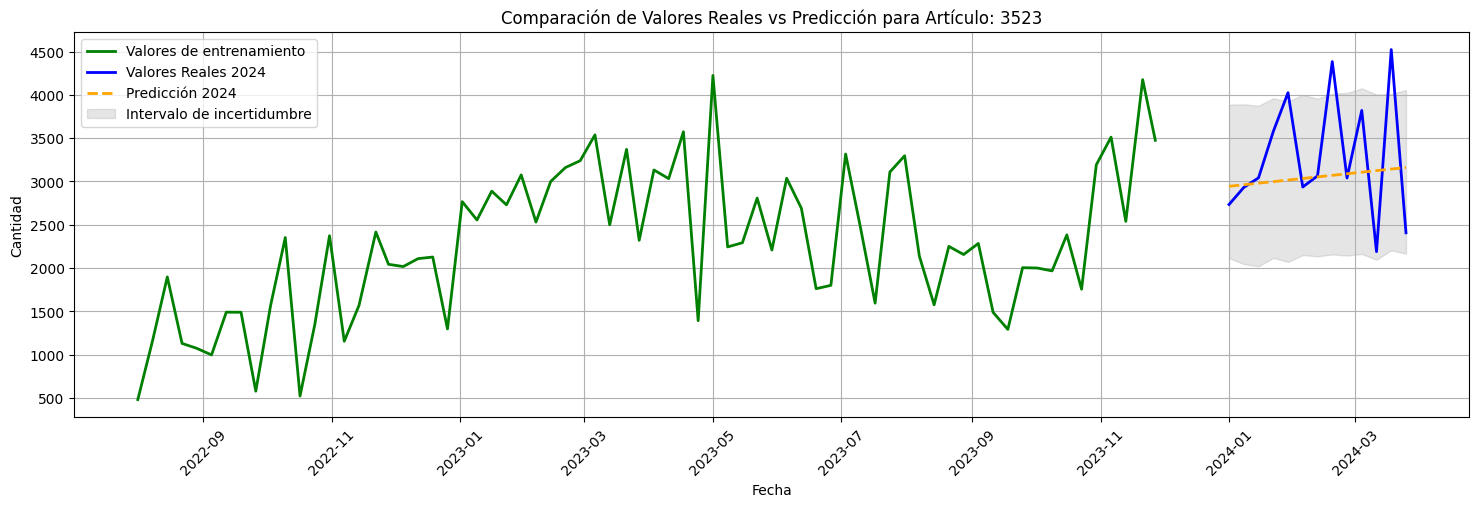

14:54:37 - cmdstanpy - INFO - Chain [1] start processing


MAE (Error Absoluto Medio): 550.01
RMSE (Raíz del Error Cuadrático Medio): 733.94
R2 (Coeficiente de Determinación): -0.10


14:54:37 - cmdstanpy - INFO - Chain [1] done processing


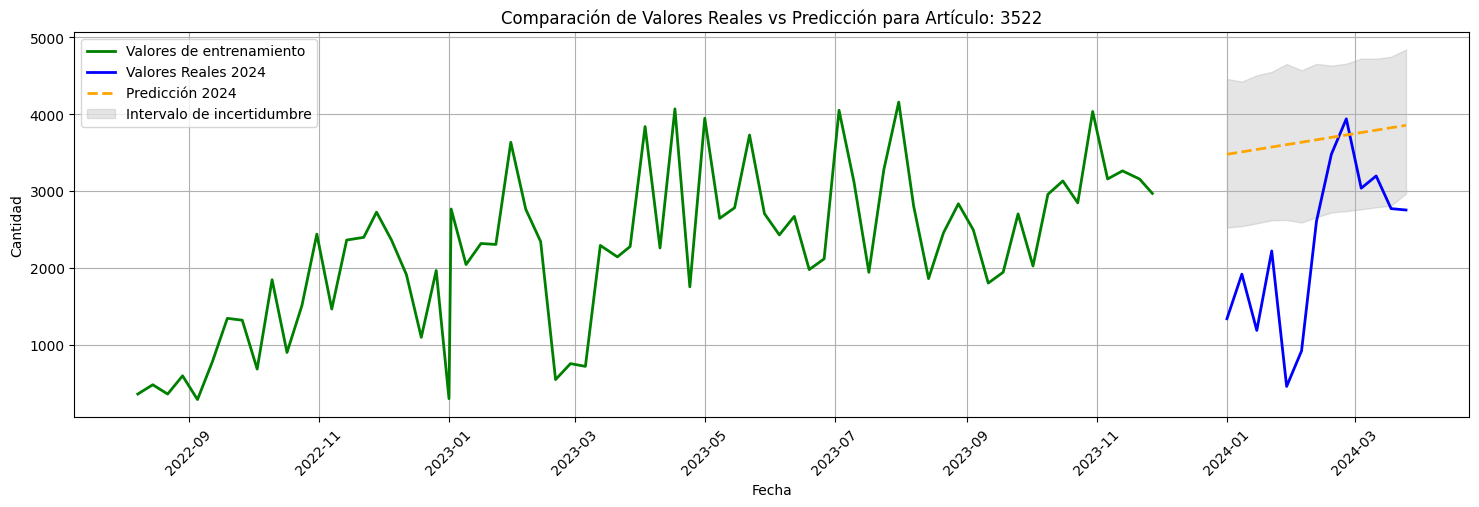

14:54:38 - cmdstanpy - INFO - Chain [1] start processing


MAE (Error Absoluto Medio): 1404.85
RMSE (Raíz del Error Cuadrático Medio): 1668.17
R2 (Coeficiente de Determinación): -1.67


14:54:38 - cmdstanpy - INFO - Chain [1] done processing


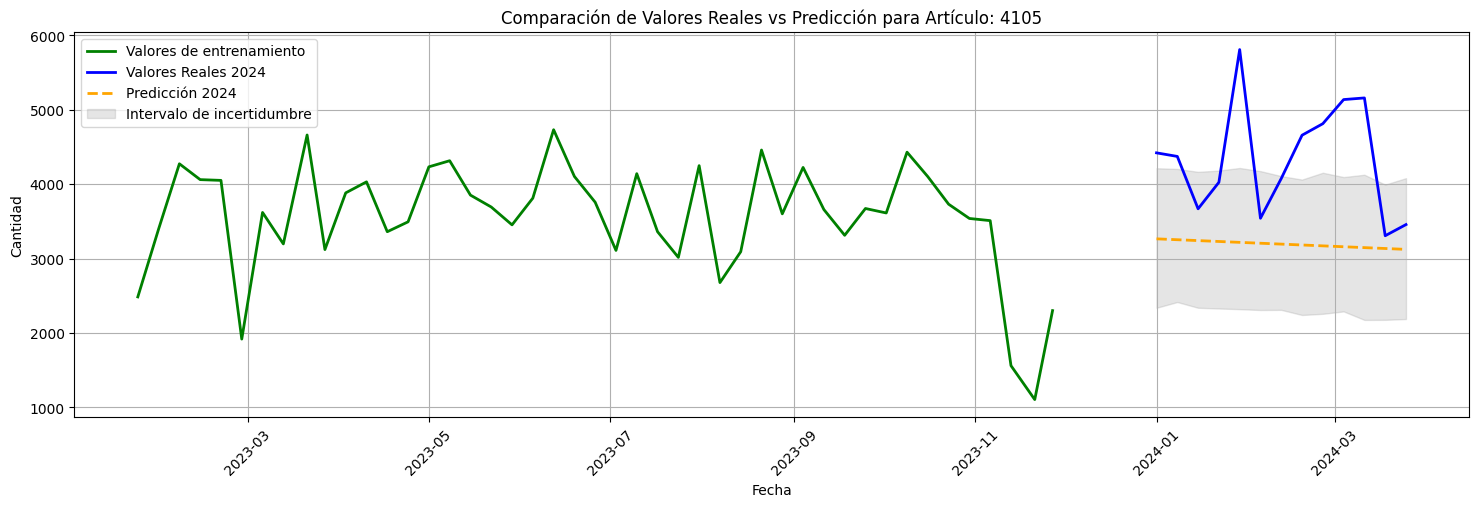

MAE (Error Absoluto Medio): 1147.55
RMSE (Raíz del Error Cuadrático Medio): 1358.17
R2 (Coeficiente de Determinación): -2.48


In [43]:
# Obtener la lista de artículos únicos
articulos_unicos = df['numero_articulo'].unique()

# Crear una gráfica por cada artículo
for articulo in articulos_unicos:
    # Filtrar los datos por artículo
    train_articulo  = train[train['numero_articulo'] == articulo] 
    #train_articulo  = train_articulo.groupby("fecha_emision")[["cantidad", "costo_total"]].sum().reset_index()
    train_articulo  = train_articulo.groupby("fecha_inicio_semana")["cantidad"].sum().reset_index()
    train_articulo  = train_articulo.rename(columns={'fecha_inicio_semana': 'ds', 'cantidad': 'y'})

    valid_articulo  = valid[valid['numero_articulo'] == articulo] 
    valid_articulo  = valid_articulo.groupby("fecha_inicio_semana")["cantidad"].sum().reset_index()
    valid_articulo  = valid_articulo.rename(columns={'fecha_inicio_semana': 'ds', 'cantidad': 'y'})
    
    valid_articulo

    # Continuar solo si hay datos suficientes
    if len(train_articulo) == 0 or len(valid_articulo) == 0:
        continue

    # Inicializar y entrenar el modelo Prophet
    model           = Prophet()
    #model.add_regressor("costo_total")
    model.fit(train_articulo)

    
    # Crear horizonte de predicción con las fechas de validación
    future          = valid_articulo[['ds']].copy()
    forecast        = model.predict(future)


    #Prediccion para los siguientes 3 Meses
    future_3_meses  = model.make_future_dataframe(periods=3, freq="ME")

    # Filtrar solo las fechas de 2024
    valid_2024      = valid_articulo
    forecast_2024   = forecast

    # Graficar valores reales y predicciones
    plt.figure(figsize=(18, 5))
    plt.plot(train_articulo['ds'], train_articulo['y'], label='Valores de entrenamiento', color='green', linewidth=2)
    plt.plot(valid_2024['ds'], valid_2024['y'], label='Valores Reales 2024', color='blue', linewidth=2)
    plt.plot(forecast_2024['ds'], forecast_2024['yhat'], label='Predicción 2024', linestyle='--', color='orange', linewidth=2)
    plt.fill_between(forecast_2024['ds'], forecast_2024['yhat_lower'], forecast_2024['yhat_upper'], 
                     color='gray', alpha=0.2, label='Intervalo de incertidumbre')
    plt.xticks(rotation=45)

    # Configuración de la gráfica
    plt.title(f"Comparación de Valores Reales vs Predicción para Artículo: {articulo}")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad")
    plt.legend()
    plt.grid()
    plt.show()

    # Calcular métricas de desempeño
    mae = mean_absolute_error(valid_2024['y'], forecast_2024['yhat'])
    rmse = np.sqrt(mean_squared_error(valid_2024['y'], forecast_2024['yhat']))
    r2 = r2_score(valid_2024['y'], forecast_2024['yhat'])

    print(f"MAE (Error Absoluto Medio): {mae:.2f}")
    print(f"RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}")
    print(f"R2 (Coeficiente de Determinación): {r2:.2f}")

    
    